In [ ]:
!pip install shap
!pip install catboost

     |████████████████████████████████| 358kB 7.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=293e043e25f585f7c6f3a0a8afbff7caa53b76b798d06a19d8cea10bdb46e26a
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 69.2MB 42kB/s 


In [ ]:
import io
import pandas as pd
import catboost as cb
import numpy as np
import seaborn as sns
import shap
import os
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import files
upload = files.upload()
upload1 = files.upload()

Saving Kirinyaga_processed_data.csv to Kirinyaga_processed_data.csv


Saving Kirinyaga_cat.csv to Kirinyaga_cat.csv


In [ ]:
df_imputed = pd.read_csv(io.BytesIO(upload['Kirinyaga_processed_data.csv']), parse_dates=['Date'], index_col='Date')

In [ ]:
df_imputed

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10.0,0.0,0.0,20.0,283.0,50.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,455.0,42.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16500.0,261.0,0.0,0.0,50.0,1707.0,203.0,2300.0,0.0,1.0,0.0,150.0,22.0,443.0,0.0,13.0,0.0,32.0,0.0,169.0,800.0,50.0,2920.0,1100.0,0.0,20.0,6.0,0.0,361.0,149.0,40.0,0.0,70.0,80.0,145.0,10.0,400.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1450.0,120.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1680.0,0.0,1680.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,720.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,20.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,70.0,10.0,2.0,4.0,0.0,0.0,0.0,0.0
2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2019-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
df_imputed = df_imputed.sample(frac=1)
df_imputed

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,250.0,153.0,310.0,0.0,100.0,0.0,0.0,1.0,1.0,1.0,0.0,20.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,17800.0,0.0,0.0,430.0,250.0,0.0,523.0,0.0,0.0,3.0,25.0,0.0,20.0,0.0,3283.0,45.0,500.0,28.0,5.0,2.0,0.0,20.0,20.0,20.0,0.0,0.0,93.0,0.0,5.0,10.0,0.0,0.0,30.0,25.0,5.0,2.0,733.0,0.0,0.0,6.0
2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4700.0,0.0,0.0,100.0,0.0,0.0,190.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1100.0,0.0,40.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,20.0,0.0,0.0,5.0
2020-08-01,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,90.0,200.0,0.0,10.0,50.0,300.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,300.0,20.0,10.0,0.0
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,0.0,5.0,30.0,0.0,20.0,97.0,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,0.0,265.0,4.0,10.0,100.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,253.0,298.0,0.0,0.0,0.0,0.0,0.0,140.0,140.0,200.0,300.0,0.0,0.0,10.0,30.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,6.0,0.0,0.0,...,65900.0,0.0,0.0,340.0,50.0,0.0,1312.0,0.0,0.0,5.0,0.0,0.0,71.0,0.0,8416.0,89.0,0.0,2.0,855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,20.0,17.0,340.0,5.0,30.0,0.0
2019-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,20.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,70.0,10.0,2.0,4.0,0.0,0.0,0.0,0.0
2019-01-01,10.0,0.0,0.0,20.0,283.0,50.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,455.0,42.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16

In [ ]:
size = int(df_imputed.shape[0]*0.75)
train_set = df_imputed.iloc[0:size,:]
test_set = df_imputed.iloc[size:]

In [ ]:
test_set

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,250.0,153.0,310.0,0.0,100.0,0.0,0.0,1.0,1.0,1.0,0.0,20.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,17800.0,0.0,0.0,430.0,250.0,0.0,523.0,0.0,0.0,3.0,25.0,0.0,20.0,0.0,3283.0,45.0,500.0,28.0,5.0,2.0,0.0,20.0,20.0,20.0,0.0,0.0,93.0,0.0,5.0,10.0,0.0,0.0,30.0,25.0,5.0,2.0,733.0,0.0,0.0,6.0
2020-08-01,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,90.0,200.0,0.0,10.0,50.0,300.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,300.0,20.0,10.0,0.0
2020-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,500.0,500.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,500.0,0.0,500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4700.0,0.0,0.0,100.0,0.0,0.0,190.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1100.0,0.0,40.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,20.0,0.0,0.0,5.0
2020-12-01,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_set

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10.0,0.0,0.0,20.0,283.0,50.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,455.0,42.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16500.0,261.0,0.0,0.0,50.0,1707.0,203.0,2300.0,0.0,1.0,0.0,150.0,22.0,443.0,0.0,13.0,0.0,32.0,0.0,169.0,800.0,50.0,2920.0,1100.0,0.0,20.0,6.0,0.0,361.0,149.0,40.0,0.0,70.0,80.0,145.0,10.0,400.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1450.0,120.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1680.0,0.0,1680.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,720.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,20.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,70.0,10.0,2.0,4.0,0.0,0.0,0.0,0.0
2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2019-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
tf = train_set.T
tf

Date,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01
EG04GEN085,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EM03HAE003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,0.0,0.0
EM03HAE004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
EM08SUC004,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0
EM10XYM004,283.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PV01SER003,10.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,6.0,0.0,0.0,0.0,17.0,0.0,0.0
PV01SER004,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1270.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0
PV01SER011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
PV01SER012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler()
scaler = min_max_scaler.fit_transform(tf)
scaler

array([[1.99001015e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.02124431e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06980273e-05, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58725341e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.55235205e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
df_train = pd.DataFrame(scaler)
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000199,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.004021,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.000061,0.000000,0.0
3,0.000398,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.000152,0.000893,0.0
4,0.005632,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.001517,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.000199,0.0,0.002222,0.0,0.0,0.0,0.0,0.002857,0.0,0.000124,0.015,0.0,0.0,0.0,0.000258,0.000000,0.0
687,0.007960,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.026240,0.000,0.0,0.0,0.0,0.005159,0.000000,0.0
688,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.000076,0.000000,0.0
689,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.000455,0.000000,0.0


In [ ]:
df_train = df_train.T
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
0,0.000199,0.000000,0.000000,0.000398,0.005632,0.000995,0.00199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.009055,0.000836,0.002587,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.328352,0.005194,0.000000,0.000000,0.000995,0.033969,0.004040,0.045770,0.000000,0.000020,0.000000,0.002985,0.000438,0.008816,0.000000,0.000259,0.0000,0.000637,0.000000,0.003363,0.015920,0.000995,0.058108,0.021890,0.000000,0.000398,0.000119,0.000000,0.007184,0.002965,0.000796,0.000000,0.001393,0.001592,0.002886,0.000199,0.007960,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.15,0.725,0.06,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.03,0.84,0.000000,0.84,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.0000,0.000000,0.360000,0.000000,0.000000,0.005000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022778,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.011111,0.000000,0.000000,0.000000,0.082778,0.000000,0.000000,0.000000,0.038889,0.005556,0.001111,0.002222,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001026,0

In [ ]:
df_train.columns = df_imputed.columns
df_train

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
0,0.000199,0.000000,0.000000,0.000398,0.005632,0.000995,0.00199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.009055,0.000836,0.002587,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.328352,0.005194,0.000000,0.000000,0.000995,0.033969,0.004040,0.045770,0.000000,0.000020,0.000000,0.002985,0.000438,0.008816,0.000000,0.000259,0.0000,0.000637,0.000000,0.003363,0.015920,0.000995,0.058108,0.021890,0.000000,0.000398,0.000119,0.000000,0.007184,0.002965,0.000796,0.000000,0.001393,0.001592,0.002886,0.000199,0.007960,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.15,0.725,0.06,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.03,0.84,0.000000,0.84,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.0000,0.000000,0.360000,0.000000,0.000000,0.005000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022778,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.011111,0.000000,0.000000,0.000000,0.082778,0.000000,0.000000,0.000000,0.038889,0.005556,0.001111,0.002222,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000

In [ ]:
df_train.index = train_set.index
df_train

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.000199,0.000000,0.000000,0.000398,0.005632,0.000995,0.00199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.009055,0.000836,0.002587,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.328352,0.005194,0.000000,0.000000,0.000995,0.033969,0.004040,0.045770,0.000000,0.000020,0.000000,0.002985,0.000438,0.008816,0.000000,0.000259,0.0000,0.000637,0.000000,0.003363,0.015920,0.000995,0.058108,0.021890,0.000000,0.000398,0.000119,0.000000,0.007184,0.002965,0.000796,0.000000,0.001393,0.001592,0.002886,0.000199,0.007960,0.000000,0.000000,0.0
2019-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.15,0.725,0.06,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.03,0.84,0.000000,0.84,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.0000,0.000000,0.360000,0.000000,0.000000,0.005000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022778,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.011111,0.000000,0.000000,0.000000,0.082778,0.000000,0.000000,0.000000,0.038889,0.005556,0.001111,0.002222,0.000000,0.000000,0.000000,0.0
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
train = df_train
train

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.000199,0.000000,0.000000,0.000398,0.005632,0.000995,0.00199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.009055,0.000836,0.002587,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.328352,0.005194,0.000000,0.000000,0.000995,0.033969,0.004040,0.045770,0.000000,0.000020,0.000000,0.002985,0.000438,0.008816,0.000000,0.000259,0.0000,0.000637,0.000000,0.003363,0.015920,0.000995,0.058108,0.021890,0.000000,0.000398,0.000119,0.000000,0.007184,0.002965,0.000796,0.000000,0.001393,0.001592,0.002886,0.000199,0.007960,0.000000,0.000000,0.0
2019-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.15,0.725,0.06,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.03,0.84,0.000000,0.84,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.0000,0.000000,0.360000,0.000000,0.000000,0.005000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022778,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.011111,0.000000,0.000000,0.000000,0.082778,0.000000,0.000000,0.000000,0.038889,0.005556,0.001111,0.002222,0.000000,0.000000,0.000000,0.0
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
#test set preparation
tt = test_set.T
tt

Date,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-11-01,2020-12-01
EG04GEN085,0.0,0.0,0.0,0.0,0.0,0.0
EM03HAE003,0.0,0.0,400.0,0.0,0.0,25.0
EM03HAE004,0.0,0.0,0.0,0.0,0.0,0.0
EM08SUC004,0.0,0.0,0.0,0.0,0.0,0.0
EM10XYM004,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
PV01SER003,0.0,2.0,0.0,0.0,0.0,0.0
PV01SER004,0.0,733.0,300.0,0.0,20.0,0.0
PV01SER011,0.0,0.0,20.0,0.0,0.0,0.0
PV01SER012,0.0,0.0,10.0,0.0,0.0,0.0


In [ ]:
scale = min_max_scaler.fit_transform(tt)
scale

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02325581, 0.        , 0.        ,
        0.11363636],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00116279, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0005814 , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00020906, 0.        , 0.        , 0.00033333,
        0.        ]])

In [ ]:
df_test = pd.DataFrame(scale)
df_test

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.023256,0.0,0.000000,0.113636
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...
686,0.0,0.000070,0.000000,0.0,0.000000,0.000000
687,0.0,0.025540,0.017442,0.0,0.001333,0.000000
688,0.0,0.000000,0.001163,0.0,0.000000,0.000000
689,0.0,0.000000,0.000581,0.0,0.000000,0.000000


In [ ]:
df_test = df_test.T
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00125,0.000833,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003484,0.003484,0.0,0.0,0.0,0.00000,0.000000,0.008711,0.005331,0.010801,0.00,0.003484,0.0,0.00,0.000035,0.000035,0.000035,0.000000,0.000697,0.000000,0.000000,0.000000,0.00007,0.000035,0.000,0.0,0.000000,0.0,0.000035,0.000000,0.000000,0.0,...,0.620209,0.0,0.0,0.014983,0.008711,0.0,0.018223,0.0,0.0,0.000105,0.000871,0.0,0.000697,0.0,0.114390,0.001568,0.017422,0.000976,0.000174,0.00007,0.0,0.000697,0.000697,0.000697,0.0,0.0,0.003240,0.0,0.000174,0.000348,0.0,0.0,0.001045,0.000871,0.000174,0.00007,0.025540,0.000000,0.000000,0.000209
2,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000581,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.004070,0.004070,0.005233,0.011628,0.000000,0.000581,0.002907,0.017442,0.00000,0.000000,0.000,0.0,0.006977,0.0,0.000000,0.002907,0.000000,0.0,...,0.000000,0.0,0.0,0.007558,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.029070,0.000000,0.000000,0.002326,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.004651,0.000000,0.00000,0.017442,0.001163,0.000581,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.06,0.100000,0.1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.007,0.1,0.000000,0.1,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.003333,0.000000,0.001667,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.313333,0.0,0.0,0.006667,0.000000,0.0,0.012667,0.0,0.0,0.000133,0.000000,0.0,0.000000,0.0,0.073333,0.000000,0.002667,0.001333,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000667,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001533,0.000000,0.00000,0.001333,0.000000,0.000000,0.000333
5,0.0,0.113636,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.059091,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df_test.columns = test_set.columns
df_test

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00125,0.000833,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003484,0.003484,0.0,0.0,0.0,0.00000,0.000000,0.008711,0.005331,0.010801,0.00,0.003484,0.0,0.00,0.000035,0.000035,0.000035,0.000000,0.000697,0.000000,0.000000,0.000000,0.00007,0.000035,0.000,0.0,0.000000,0.0,0.000035,0.000000,0.000000,0.0,...,0.620209,0.0,0.0,0.014983,0.008711,0.0,0.018223,0.0,0.0,0.000105,0.000871,0.0,0.000697,0.0,0.114390,0.001568,0.017422,0.000976,0.000174,0.00007,0.0,0.000697,0.000697,0.000697,0.0,0.0,0.003240,0.0,0.000174,0.000348,0.0,0.0,0.001045,0.000871,0.000174,0.00007,0.025540,0.000000,0.000000,0.000209
2,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000581,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.004070,0.004070,0.005233,0.011628,0.000000,0.000581,0.002907,0.017442,0.00000,0.000000,0.000,0.0,0.006977,0.0,0.000000,0.002907,0.000000,0.0,...,0.000000,0.0,0.0,0.007558,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.029070,0.000000,0.000000,0.002326,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.004651,0.000000,0.00000,0.017442,0.001163,0.000581,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.06,0.100000,0.1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.007,0.1,0.000000,0.1,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.003333,0.000000,0.001667,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.313333,0.0,0.0,0.006667,0.000000,0.0,0.012667,0.0,0.0,0.000133,0.000000,0.0,0.000000,0.0,0.073333,0.000000,0.002667,0.001333,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000667,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001533,0.000000,0.00000,0.001333,0.000000,0.000000,0.000333
5,0.0,0.113636,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.00000,0.000000,0.000,0.0,

In [ ]:
df_test.index = test_set.index
df_test

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00125,0.000833,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2020-07-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003484,0.003484,0.0,0.0,0.0,0.00000,0.000000,0.008711,0.005331,0.010801,0.00,0.003484,0.0,0.00,0.000035,0.000035,0.000035,0.000000,0.000697,0.000000,0.000000,0.000000,0.00007,0.000035,0.000,0.0,0.000000,0.0,0.000035,0.000000,0.000000,0.0,...,0.620209,0.0,0.0,0.014983,0.008711,0.0,0.018223,0.0,0.0,0.000105,0.000871,0.0,0.000697,0.0,0.114390,0.001568,0.017422,0.000976,0.000174,0.00007,0.0,0.000697,0.000697,0.000697,0.0,0.0,0.003240,0.0,0.000174,0.000348,0.0,0.0,0.001045,0.000871,0.000174,0.00007,0.025540,0.000000,0.000000,0.000209
2020-08-01,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000581,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.004070,0.004070,0.005233,0.011628,0.000000,0.000581,0.002907,0.017442,0.00000,0.000000,0.000,0.0,0.006977,0.0,0.000000,0.002907,0.000000,0.0,...,0.000000,0.0,0.0,0.007558,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.029070,0.000000,0.000000,0.002326,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.004651,0.000000,0.00000,0.017442,0.001163,0.000581,0.000000
2020-09-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.06,0.100000,0.1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.007,0.1,0.000000,0.1,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2020-11-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.003333,0.000000,0.001667,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.313333,0.0,0.0,0.006667,0.000000,0.0,0.012667,0.0,0.0,0.000133,0.000000,0.0,0.000000,0.0,0.073333,0.000000,0.002667,0.001333,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000667,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001533,0.000000,0.00000,0.001333,0.000000,0.000000,0.000333
2020-12-01,0.0,0.113636,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,

In [ ]:
test = df_test
test

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00125,0.000833,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2020-07-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003484,0.003484,0.0,0.0,0.0,0.00000,0.000000,0.008711,0.005331,0.010801,0.00,0.003484,0.0,0.00,0.000035,0.000035,0.000035,0.000000,0.000697,0.000000,0.000000,0.000000,0.00007,0.000035,0.000,0.0,0.000000,0.0,0.000035,0.000000,0.000000,0.0,...,0.620209,0.0,0.0,0.014983,0.008711,0.0,0.018223,0.0,0.0,0.000105,0.000871,0.0,0.000697,0.0,0.114390,0.001568,0.017422,0.000976,0.000174,0.00007,0.0,0.000697,0.000697,0.000697,0.0,0.0,0.003240,0.0,0.000174,0.000348,0.0,0.0,0.001045,0.000871,0.000174,0.00007,0.025540,0.000000,0.000000,0.000209
2020-08-01,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000581,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.004070,0.004070,0.005233,0.011628,0.000000,0.000581,0.002907,0.017442,0.00000,0.000000,0.000,0.0,0.006977,0.0,0.000000,0.002907,0.000000,0.0,...,0.000000,0.0,0.0,0.007558,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.029070,0.000000,0.000000,0.002326,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.004651,0.000000,0.00000,0.017442,0.001163,0.000581,0.000000
2020-09-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.06,0.100000,0.1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.007,0.1,0.000000,0.1,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2020-11-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.003333,0.000000,0.001667,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.313333,0.0,0.0,0.006667,0.000000,0.0,0.012667,0.0,0.0,0.000133,0.000000,0.0,0.000000,0.0,0.073333,0.000000,0.002667,0.001333,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000667,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001533,0.000000,0.00000,0.001333,0.000000,0.000000,0.000333
2020-12-01,0.0,0.113636,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = list(df.index.get_level_values('Date'))
    df['dayofweek'] = df['date'].dt.dayofweek 
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']] = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    return df

In [ ]:
class_df = pd.read_csv(io.BytesIO(upload1['Kirinyaga_cat.csv']), index_col=None)

In [ ]:
LE = LabelEncoder()

In [ ]:
def add_features(class_df,df,LE):
    
    #transpose 
    class_df = class_df.T
    
    #modify
    class_df.reset_index(inplace=True)
    
    #delete extra index
    class_df.drop(class_df.columns[[0]],axis=1,inplace=True)
    #rename header 
    class_df.columns = class_df.iloc[0]
    #delete first row
    class_df = class_df.iloc[1:]
    #rename product_id columns for merge
    class_df.rename({class_df.columns[0]:"products"},axis=1,inplace=True)
    #main df to long format 
    df.reset_index(inplace=True)
    df = df.melt(id_vars=['Date'], var_name='products', value_name='Demands')
    dfinal = pd.merge(df, class_df, on='products')
    
    

    dfinal['orginial_id'] = dfinal['products']
    
    dfinal['products'] = LE.fit_transform(dfinal['products'])
    
    dummy = ['Category']
    dfx = pd.get_dummies(dfinal,columns=dummy)
    
    
    #add multi-index [date, products]
    return pd.DataFrame(dfx.groupby(['Date','products'])[dfx.columns[2:]].sum())

In [ ]:
train_feat = add_features(class_df,train,LE)
train_feat

Demands  ...  Category_X-RAY
Date       products            ...                
2019-01-01 0         0.000199  ...               0
           1         0.000000  ...               0
           2         0.000000  ...               0
           3         0.000398  ...               0
           4         0.005632  ...               0
...                       ...  ...             ...
2020-05-01 686       0.000000  ...               0
           687       0.000000  ...               0
           688       0.000000  ...               0
           689       0.000000  ...               0
           690       0.000000  ...               0

[11747 rows x 12 columns]

In [ ]:
train_feat_time = create_features(train_feat)
train_feat_time

Demands  ...  weekofyear
Date       products            ...            
2019-01-01 0         0.000199  ...           1
           1         0.000000  ...           1
           2         0.000000  ...           1
           3         0.000398  ...           1
           4         0.005632  ...           1
...                       ...  ...         ...
2020-05-01 686       0.000000  ...          18
           687       0.000000  ...          18
           688       0.000000  ...          18
           689       0.000000  ...          18
           690       0.000000  ...          18

[11747 rows x 20 columns]

In [ ]:
train_feat_time.drop('date',axis=1,inplace=True)
train_feat_time

Demands  ...  weekofyear
Date       products            ...            
2019-01-01 0         0.000199  ...           1
           1         0.000000  ...           1
           2         0.000000  ...           1
           3         0.000398  ...           1
           4         0.005632  ...           1
...                       ...  ...         ...
2020-05-01 686       0.000000  ...          18
           687       0.000000  ...          18
           688       0.000000  ...          18
           689       0.000000  ...          18
           690       0.000000  ...          18

[11747 rows x 19 columns]

In [ ]:
test_feat = add_features(class_df,test,LE)
test_feat

Demands  ...  Category_X-RAY
Date       products           ...                
2020-06-01 0             0.0  ...               0
           1             0.0  ...               0
           2             0.0  ...               0
           3             0.0  ...               0
           4             0.0  ...               0
...                      ...  ...             ...
2020-12-01 686           0.0  ...               0
           687           0.0  ...               0
           688           0.0  ...               0
           689           0.0  ...               0
           690           0.0  ...               0

[4146 rows x 12 columns]

In [ ]:
test_feat_time = create_features(test_feat)
test_feat_time

Demands  ...  weekofyear
Date       products           ...            
2020-06-01 0             0.0  ...          23
           1             0.0  ...          23
           2             0.0  ...          23
           3             0.0  ...          23
           4             0.0  ...          23
...                      ...  ...         ...
2020-12-01 686           0.0  ...          49
           687           0.0  ...          49
           688           0.0  ...          49
           689           0.0  ...          49
           690           0.0  ...          49

[4146 rows x 20 columns]

In [ ]:
test_feat_time.drop('date',axis=1,inplace=True)
test_feat_time

Demands  ...  weekofyear
Date       products           ...            
2020-06-01 0             0.0  ...          23
           1             0.0  ...          23
           2             0.0  ...          23
           3             0.0  ...          23
           4             0.0  ...          23
...                      ...  ...         ...
2020-12-01 686           0.0  ...          49
           687           0.0  ...          49
           688           0.0  ...          49
           689           0.0  ...          49
           690           0.0  ...          49

[4146 rows x 19 columns]

In [ ]:
y_train = train_feat.drop(train_feat.columns[1:],axis=1)
X_train = train_feat.drop('Demands',axis=1)

In [ ]:
y_test = test_feat.drop(test_feat.columns[1:],axis=1)
X_test = test_feat.drop('Demands',axis=1)

In [ ]:
X_train

Category_ASTRAZENECA ACCESS PROGRAM  ...  weekofyear
Date       products                                       ...            
2019-01-01 0                                           0  ...           1
           1                                           0  ...           1
           2                                           0  ...           1
           3                                           0  ...           1
           4                                           0  ...           1
...                                                  ...  ...         ...
2020-05-01 686                                         0  ...          18
           687                                         0  ...          18
           688                                         0  ...          18
           689                                         0  ...          18
           690                                         0  ...          18

[11747 rows x 18 columns]

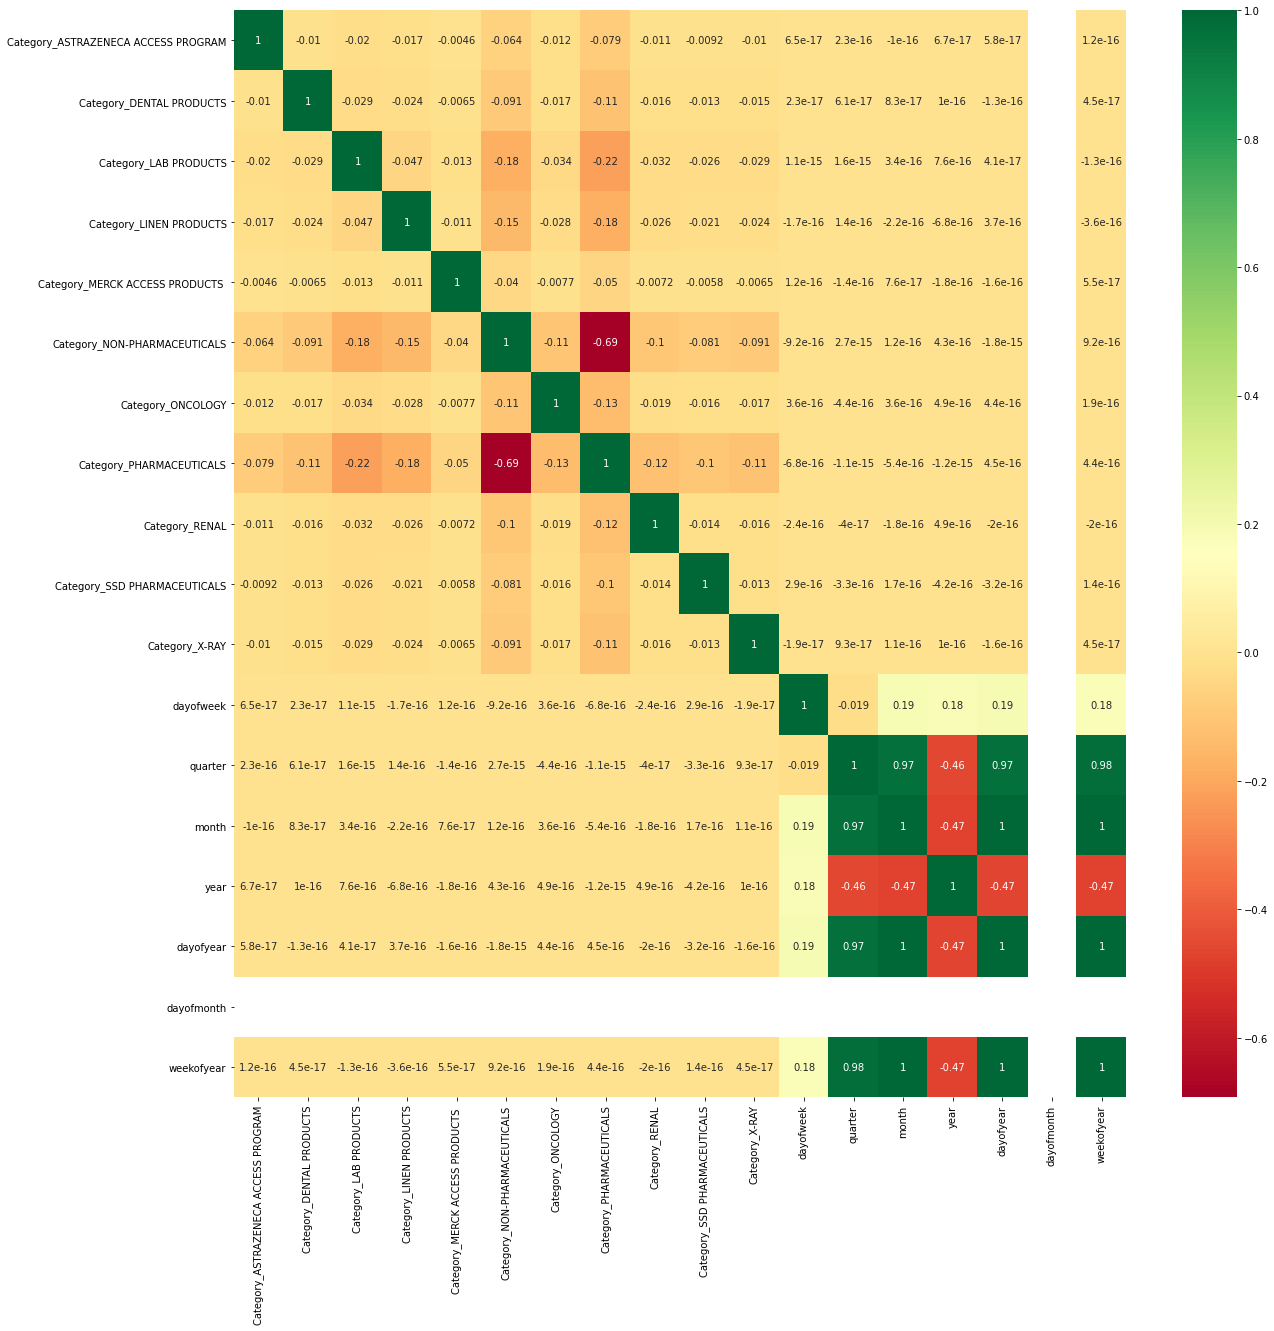

In [ ]:
corrmat = X_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20)) 
g=sns.heatmap(X_train[top_corr_features].corr(),annot=True,cmap='RdYlGn') 

In [ ]:
!pip install bayesian_optimization


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=0cf1fe4e56bb75cd0bb5e37743630b0dd69fb092d6290c0d9f61eb1428ee907b
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.4MB/s 


In [ ]:
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn import datasets, pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb

In [ ]:
pipe = pipeline.Pipeline([
    ('regre', lgb.LGBMRegressor())
    ])
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [ ]:
num_eval = 900

In [ ]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        regre = lgb.LGBMRegressor(**params)
        score = cross_val_score(regre, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    regre_best = lgb.LGBMRegressor(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    regre_best.fit(X_train, y_train)
    
    print("Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", regre_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [ ]:
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

100%|██████████| 900/900 [04:36<00:00,  3.26it/s, best loss: 0.004331269721770758]
Results
Score best parameters:  -0.004331269721770758
Best parameters:  {'boosting_type': 1, 'colsample_by_tree': 0.6395676280698441, 'learning_rate': 0.011024062892374942, 'max_depth': 14.0, 'n_estimators': 30.0, 'num_leaves': 18.0, 'reg_lambda': 0.8884691115854055}
Test Score:  -0.0016505518088114624
Time elapsed:  276.1862111091614
Parameter combinations evaluated:  900


In [ ]:
y_test

Demands
Date       products         
2020-06-01 0             0.0
           1             0.0
           2             0.0
           3             0.0
           4             0.0
...                      ...
2020-12-01 686           0.0
           687           0.0
           688           0.0
           689           0.0
           690           0.0

[4146 rows x 1 columns]

In [ ]:
parameters = {'num_iterations':[4,8,9,10], 
              'objective':['regression'],
              'boosting_type': ['gdbt','dart'],
              'learning_rate': [.03, 0.05, .07,0.1,0.2,0.3,0.5,0.7,0.8], 
              'num_depth': [1, 3, 4,7,10],
              'num_leaves':[10,16,32,64,100],
              'subsample': [0.3,0.5,0.8],
              'feature_fraction': [0.6,0.8]}

In [ ]:
lgb = LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb, param_grid=parameters)
gsearch.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=T...
             param_grid={'boosting_type': ['gdbt', 'dart'],
                         'feature_fraction': [0.6, 0.8],
                         'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.5,
                                           0.7, 0.8],
                         'num_depth': [1, 3, 4, 7, 10],
                         'num_iterations': [4, 8

In [ ]:
#not optimal
gsearch.best_estimator_

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.6, importance_type='split', learning_rate=0.2,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_depth=1,
              num_iterations=9, num_leaves=10, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.3, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#not optimal
gsearch.best_params_

{'boosting_type': 'dart',
 'feature_fraction': 0.6,
 'learning_rate': 0.03,
 'num_depth': 1,
 'num_iterations': 8,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.3}

In [ ]:
lgb = LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree= 0.6395676280698441,
              feature_fraction=0.6, importance_type='split', learning_rate=0.27,
              max_depth=14, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_depth=1,
              num_iterations=8, num_leaves=18, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda= 0.8884691115854055, silent=True,
              subsample=0.3, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#not optimal
lgb = LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=0.7106265905682273,
              feature_fraction=0.6, importance_type='split', learning_rate=0.0924161897382903,
              max_depth=12, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=7, n_jobs=-1, num_depth=1,
              num_iterations=4, num_leaves=6, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.7977570450280574, silent=True,
              subsample=0.3, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#optimal
lgb = LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.6, importance_type='split', learning_rate=0.35,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_depth=7,
              num_iterations=10, num_leaves=64, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.6, subsample_for_bin=200000, subsample_freq=0, max_bin=255)

TRAIN DATA METRICS: 
R2 Score is:  0.05877794452407903
mean_squared_error Score is:  0.0032626518277996948
mean_absolute_error Score is:  0.0137120369088732
Test data metrics
R2 Score is:  0.003861085639123907
mean_squared_error Score is:  0.003915768071923442
mean_absolute_error Score is:  0.014656046334662892


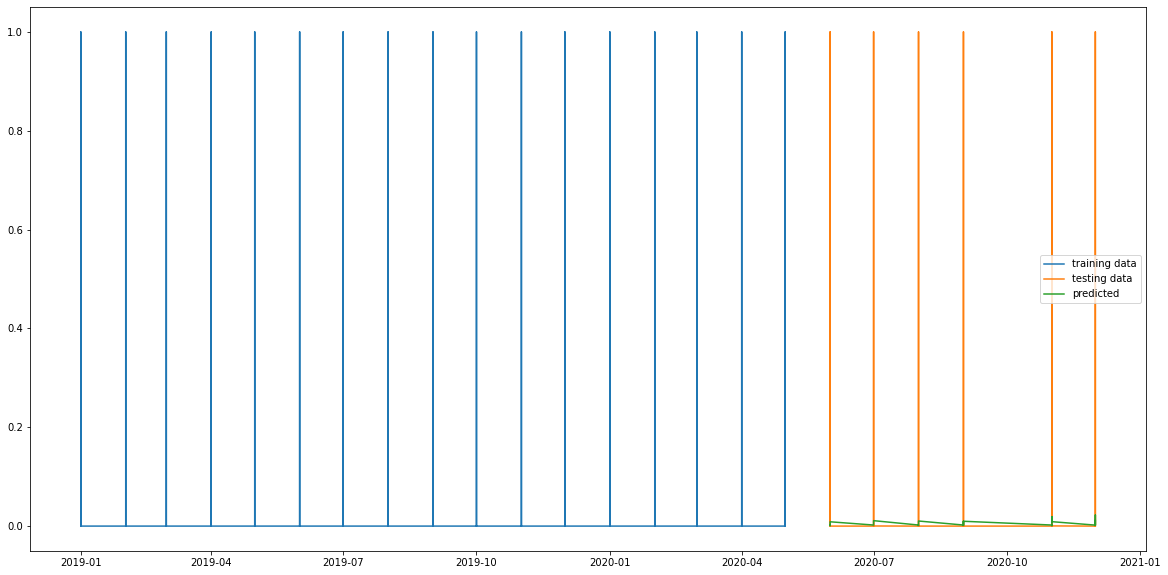

In [ ]:
    
lgb.fit(X_train, y_train)

pred = lgb.predict(X_test)
    
print("TRAIN DATA METRICS: ")
print("R2 Score is: ",r2_score(y_train, lgb.predict(X_train)))
print("mean_squared_error Score is: ",mean_squared_error(y_train, lgb.predict(X_train)))
print("mean_absolute_error Score is: ",mean_absolute_error(y_train, lgb.predict(X_train)))



print("Test data metrics")

print("R2 Score is: ",r2_score(y_test, pred))
print("mean_squared_error Score is: ",mean_squared_error(y_test, pred))
print("mean_absolute_error Score is: ",mean_absolute_error(y_test, pred))



    #plot
plt.figure(figsize=(20,10))
plt.plot(y_train.index.get_level_values(level = 'Date'), y_train, label='training data')
plt.plot(y_test.index.get_level_values(level = 'Date'), y_test, label='testing data')
plt.plot(y_test.index.get_level_values(level = 'Date'), pred, label="predicted")
plt.legend(loc='best');
plt.show()

In [ ]:
pred = lgb.predict(X_test)
#pred= np.clip(pred, y_test['Demands'].min(), y_test['Demands'].max())

In [ ]:
min(pred)

0.0009557367628056216

In [ ]:
y = pd.DataFrame(pred)
y

,0
0,0.001766
1,0.000956
2,0.000956
3,0.001766
4,0.001766
...,...
4141,0.011171
4142,0.011171
4143,0.001980
4144,0.001980


In [ ]:
y.rename({0: 'Demands'}, axis=1, inplace=True)

In [ ]:
y

,Demands
0,0.001766
1,0.000956
2,0.000956
3,0.001766
4,0.001766
...,...
4141,0.011171
4142,0.011171
4143,0.001980
4144,0.001980


In [ ]:
y_test

Demands
Date       products         
2020-06-01 0             0.0
           1             0.0
           2             0.0
           3             0.0
           4             0.0
...                      ...
2020-12-01 686           0.0
           687           0.0
           688           0.0
           689           0.0
           690           0.0

[4146 rows x 1 columns]

In [ ]:
z = y_test
z

Demands
Date       products         
2020-06-01 0             0.0
           1             0.0
           2             0.0
           3             0.0
           4             0.0
...                      ...
2020-12-01 686           0.0
           687           0.0
           688           0.0
           689           0.0
           690           0.0

[4146 rows x 1 columns]

In [ ]:
z.reset_index(inplace=True)
z

,Date,products,Demands
0,2020-06-01,0,0.0
1,2020-06-01,1,0.0
2,2020-06-01,2,0.0
3,2020-06-01,3,0.0
4,2020-06-01,4,0.0
...,...,...,...
4141,2020-12-01,686,0.0
4142,2020-12-01,687,0.0
4143,2020-12-01,688,0.0
4144,2020-12-01,689,0.0


In [ ]:
y

,Demands
0,0.001766
1,0.000956
2,0.000956
3,0.001766
4,0.001766
...,...
4141,0.011171
4142,0.011171
4143,0.001980
4144,0.001980


In [ ]:
k = z.join(y, lsuffix='Demands')
k

,Date,products,DemandsDemands,Demands
0,2020-06-01,0,0.0,0.001766
1,2020-06-01,1,0.0,0.000956
2,2020-06-01,2,0.0,0.000956
3,2020-06-01,3,0.0,0.001766
4,2020-06-01,4,0.0,0.001766
...,...,...,...,...
4141,2020-12-01,686,0.0,0.011171
4142,2020-12-01,687,0.0,0.011171
4143,2020-12-01,688,0.0,0.001980
4144,2020-12-01,689,0.0,0.001980


In [ ]:
l = k.pivot_table(index='Date', values='Demands',columns='products')
l

products,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.001766,0.000956,0.000956,0.001766,0.001766,0.001766,0.001766,0.001766,0.001766,0.001766,0.001766,0.001558,0.001766,0.001766,0.001766,0.001766,0.001766,0.001766,0.002100,0.002100,0.002100,0.002100,0.000956,0.000956,0.000956,0.000956,0.008696,0.000956,0.000956,0.000956,0.000956,0.000956,0.002100,0.002100,0.000956,0.002100,0.000956,0.000956,0.000956,0.000956,...,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.003571,0.003571,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.002100,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.003571,0.003571,0.003571,0.003571,0.003571,0.008696,0.008696,0.008696,0.008696,0.000956,0.000956,0.008696
2020-07-01,0.002139,0.002376,0.002376,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.003668,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002789,0.002789,0.002789,0.002789,0.002376,0.002376,0.002376,0.002376,0.010983,0.002376,0.002376,0.002376,0.002376,0.002376,0.002789,0.002789,0.002376,0.002789,0.002376,0.002376,0.002376,0.002376,...,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.005682,0.005682,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.002789,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.010983,0.005682,0.005682,0.005682,0.005682,0.005682,0.010983,0.010983,0.010983,0.010983,0.002376,0.002376,0.010983
2020-08-01,0.002149,0.001436,0.001436,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002728,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002789,0.002789,0.002789,0.002789,0.001436,0.001436,0.001436,0.001436,0.010260,0.001436,0.001436,0.001436,0.001436,0.001436,0.002789,0.002789,0.001436,0.002789,0.001436,0.001436,0.001436,0.001436,...,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.004742,0.004742,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.002789,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.010260,0.004742,0.004742,0.004742,0.004742,0.004742,0.010260,0.010260,0.010260,0.010260,0.001436,0.001436,0.010260
2020-09-01,0.002139,0.002376,0.002376,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.002454,0.002139,0.002139,0.002139,0.002139,0.002139,0.002139,0.001575,0.001575,0.001575,0.001575,0.002376,0.002376,0.002376,0.002376,0.009769,0.002376,0.002376,0.002376,0.002376,0.002376,0.001575,0.001575,0.002376,0.001575,0.002376,0.002376,0.002376,0.002376,...,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.004468,0.004468,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.001575,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.009769,0.004468,0.004468,0.004468,0.004468,0.004468,0.009769,0.009769,0.009769,0.009769,0.002376,0.002376,0.009769
2020-11-01,0.002149,0.001040,0.001040,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002038,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.001982,0.001982,0.001982,0.001982,0.001040,0.001040,0.001040,0.001040,0.008939,0.001040,0.001040,0.001040,0.001040,0.001040,0.001982,0.001982,0.001040,0.001982,0.001040,0.001040,0.001040,0.001040,...,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.003538,0.003538,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.001982,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.008939,0.003538,0.003538,0.003538,0.003538,0.003538,0.008939,0.008939,0

In [ ]:
m = l.T
m

Date,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-11-01,2020-12-01
products,,,,,,
0,0.001766,0.002139,0.002149,0.002139,0.002149,0.002139
1,0.000956,0.002376,0.001436,0.002376,0.001040,0.001980
2,0.000956,0.002376,0.001436,0.002376,0.001040,0.001980
3,0.001766,0.002139,0.002149,0.002139,0.002149,0.002139
4,0.001766,0.002139,0.002149,0.002139,0.002149,0.002139
...,...,...,...,...,...,...
686,0.008696,0.010983,0.010260,0.009769,0.008939,0.011171
687,0.008696,0.010983,0.010260,0.009769,0.008939,0.011171
688,0.000956,0.002376,0.001436,0.002376,0.001040,0.001980


In [ ]:
n = min_max_scaler.inverse_transform(m)
n

array([[ 21.1960296 ,  61.38145353,  36.96390719,  10.69363302,
         32.23596557,   0.47051985],
       [ 11.46884115,  68.20419989,  24.7068813 ,  11.88226479,
         15.60468069,   0.43567005],
       [ 11.46884115,  68.20419989,  24.7068813 ,  11.88226479,
         15.60468069,   0.43567005],
       ...,
       [ 11.46884115,  68.20419989,  24.7068813 ,  11.88226479,
         15.60468069,   0.43567005],
       [ 11.46884115,  68.20419989,  24.7068813 ,  11.88226479,
         15.60468069,   0.43567005],
       [104.34783624, 315.20689086, 176.46497038,  48.84510944,
        134.08555811,   2.45763659]])

In [ ]:
len(n)

691

In [ ]:
i = pd.DataFrame(n)
i

,0,1,2,3,4,5
0,21.196030,61.381454,36.963907,10.693633,32.235966,0.470520
1,11.468841,68.204200,24.706881,11.882265,15.604681,0.435670
2,11.468841,68.204200,24.706881,11.882265,15.604681,0.435670
3,21.196030,61.381454,36.963907,10.693633,32.235966,0.470520
4,21.196030,61.381454,36.963907,10.693633,32.235966,0.470520
...,...,...,...,...,...,...
686,104.347836,315.206891,176.464970,48.845109,134.085558,2.457637
687,104.347836,315.206891,176.464970,48.845109,134.085558,2.457637
688,11.468841,68.204200,24.706881,11.882265,15.604681,0.435670
689,11.468841,68.204200,24.706881,11.882265,15.604681,0.435670


In [ ]:
j = i.T
j

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
0,21.196030,11.468841,11.468841,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,18.693883,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,25.195864,25.195864,25.195864,25.195864,11.468841,11.468841,11.468841,11.468841,104.347836,11.468841,11.468841,11.468841,11.468841,11.468841,25.195864,25.195864,11.468841,25.195864,11.468841,11.468841,11.468841,11.468841,...,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,25.195864,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,42.856016,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,11.468841,11.468841,104.347836
1,61.381454,68.204200,68.204200,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,105.273768,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,80.049785,80.049785,80.049785,80.049785,68.204200,68.204200,68.204200,68.204200,315.206891,68.204200,68.204200,68.204200,68.204200,68.204200,80.049785,80.049785,68.204200,80.049785,68.204200,68.204200,68.204200,68.204200,...,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,80.049785,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,163.061537,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,68.204200,68.204200,315.206891
2,36.963907,24.706881,24.706881,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,46.922789,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,47.974087,47.974087,47.974087,47.974087,24.706881,24.706881,24.706881,24.706881,176.464970,24.706881,24.706881,24.706881,24.706881,24.706881,47.974087,47.974087,24.706881,47.974087,24.706881,24.706881,24.706881,24.706881,...,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,47.974087,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,81.555181,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,24.706881,24.706881,176.464970
3,10.693633,11.882265,11.882265,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,12.271395,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,7.876973,7.876973,7.876973,7.876973,11.882265,11.882265,11.882265,11.882265,48.845109,11.882265,11.882265,11.882265,11.882265,11.882265,7.876973,7.876973,11.882265,7.876973,11.882265,11.882265,11.882265,11.882265,...,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,7.876973,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,22.338950,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,11.882265,11.882265,48.845109
4,32.235966,15.604681,15.604681,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,30.563702,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,29.726052,29.726052,29.726052,29.726052,15.604681,15.604681,15.604681,15.604681,134.085558,15.604681,15.604681,15.604681,15.604681,15.604681,29.726052,29.726052,15.604681,29.726052,15.604681,15.604681,15.604681,15.604681,...,1

In [ ]:
y_test

,Date,products,Demands
0,2020-06-01,0,0.0
1,2020-06-01,1,0.0
2,2020-06-01,2,0.0
3,2020-06-01,3,0.0
4,2020-06-01,4,0.0
...,...,...,...
4141,2020-12-01,686,0.0
4142,2020-12-01,687,0.0
4143,2020-12-01,688,0.0
4144,2020-12-01,689,0.0


In [ ]:
y_test = y_test.pivot_table(index=['Date','products'],values='Demands')
y_test

Demands
Date       products         
2020-06-01 0             0.0
           1             0.0
           2             0.0
           3             0.0
           4             0.0
...                      ...
2020-12-01 686           0.0
           687           0.0
           688           0.0
           689           0.0
           690           0.0

[4146 rows x 1 columns]

In [ ]:
len(pred)

4146

In [ ]:
test_set

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,250.0,153.0,310.0,0.0,100.0,0.0,0.0,1.0,1.0,1.0,0.0,20.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,17800.0,0.0,0.0,430.0,250.0,0.0,523.0,0.0,0.0,3.0,25.0,0.0,20.0,0.0,3283.0,45.0,500.0,28.0,5.0,2.0,0.0,20.0,20.0,20.0,0.0,0.0,93.0,0.0,5.0,10.0,0.0,0.0,30.0,25.0,5.0,2.0,733.0,0.0,0.0,6.0
2020-08-01,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,90.0,200.0,0.0,10.0,50.0,300.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,300.0,20.0,10.0,0.0
2020-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,500.0,500.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,500.0,0.0,500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4700.0,0.0,0.0,100.0,0.0,0.0,190.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1100.0,0.0,40.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,20.0,0.0,0.0,5.0
2020-12-01,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
h = j
h

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
0,21.196030,11.468841,11.468841,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,18.693883,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,25.195864,25.195864,25.195864,25.195864,11.468841,11.468841,11.468841,11.468841,104.347836,11.468841,11.468841,11.468841,11.468841,11.468841,25.195864,25.195864,11.468841,25.195864,11.468841,11.468841,11.468841,11.468841,...,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,25.195864,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,42.856016,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,11.468841,11.468841,104.347836
1,61.381454,68.204200,68.204200,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,105.273768,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,80.049785,80.049785,80.049785,80.049785,68.204200,68.204200,68.204200,68.204200,315.206891,68.204200,68.204200,68.204200,68.204200,68.204200,80.049785,80.049785,68.204200,80.049785,68.204200,68.204200,68.204200,68.204200,...,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,80.049785,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,163.061537,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,68.204200,68.204200,315.206891
2,36.963907,24.706881,24.706881,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,46.922789,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,47.974087,47.974087,47.974087,47.974087,24.706881,24.706881,24.706881,24.706881,176.464970,24.706881,24.706881,24.706881,24.706881,24.706881,47.974087,47.974087,24.706881,47.974087,24.706881,24.706881,24.706881,24.706881,...,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,47.974087,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,81.555181,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,24.706881,24.706881,176.464970
3,10.693633,11.882265,11.882265,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,12.271395,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,7.876973,7.876973,7.876973,7.876973,11.882265,11.882265,11.882265,11.882265,48.845109,11.882265,11.882265,11.882265,11.882265,11.882265,7.876973,7.876973,11.882265,7.876973,11.882265,11.882265,11.882265,11.882265,...,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,7.876973,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,22.338950,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,11.882265,11.882265,48.845109
4,32.235966,15.604681,15.604681,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,30.563702,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,29.726052,29.726052,29.726052,29.726052,15.604681,15.604681,15.604681,15.604681,134.085558,15.604681,15.604681,15.604681,15.604681,15.604681,29.726052,29.726052,15.604681,29.726052,15.604681,15.604681,15.604681,15.604681,...,1

In [ ]:
h.index = test_set.index
h

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,21.196030,11.468841,11.468841,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,18.693883,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,25.195864,25.195864,25.195864,25.195864,11.468841,11.468841,11.468841,11.468841,104.347836,11.468841,11.468841,11.468841,11.468841,11.468841,25.195864,25.195864,11.468841,25.195864,11.468841,11.468841,11.468841,11.468841,...,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,25.195864,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,42.856016,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,11.468841,11.468841,104.347836
2020-07-01,61.381454,68.204200,68.204200,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,105.273768,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,80.049785,80.049785,80.049785,80.049785,68.204200,68.204200,68.204200,68.204200,315.206891,68.204200,68.204200,68.204200,68.204200,68.204200,80.049785,80.049785,68.204200,80.049785,68.204200,68.204200,68.204200,68.204200,...,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,80.049785,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,163.061537,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,68.204200,68.204200,315.206891
2020-08-01,36.963907,24.706881,24.706881,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,46.922789,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,47.974087,47.974087,47.974087,47.974087,24.706881,24.706881,24.706881,24.706881,176.464970,24.706881,24.706881,24.706881,24.706881,24.706881,47.974087,47.974087,24.706881,47.974087,24.706881,24.706881,24.706881,24.706881,...,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,47.974087,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,81.555181,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,24.706881,24.706881,176.464970
2020-09-01,10.693633,11.882265,11.882265,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,12.271395,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,7.876973,7.876973,7.876973,7.876973,11.882265,11.882265,11.882265,11.882265,48.845109,11.882265,11.882265,11.882265,11.882265,11.882265,7.876973,7.876973,11.882265,7.876973,11.882265,11.882265,11.882265,11.882265,...,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,7.876973,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,22.338950,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,11.882265,11.882265,48.845109
2020-11-01,32.235966,15.604681,15.604681,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,30.563702,32.235966,32.235966,32.235966,32.235966,32.235966,32.235966,29.726052,29.726052,29.726052,29.726052,15.604681,15.604681,15.604681,15.604681,134.085558,15.6

In [ ]:
h.columns = test_set.columns
h

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,21.196030,11.468841,11.468841,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,18.693883,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,25.195864,25.195864,25.195864,25.195864,11.468841,11.468841,11.468841,11.468841,104.347836,11.468841,11.468841,11.468841,11.468841,11.468841,25.195864,25.195864,11.468841,25.195864,11.468841,11.468841,11.468841,11.468841,...,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,25.195864,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,42.856016,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,11.468841,11.468841,104.347836
2020-07-01,61.381454,68.204200,68.204200,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,105.273768,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,80.049785,80.049785,80.049785,80.049785,68.204200,68.204200,68.204200,68.204200,315.206891,68.204200,68.204200,68.204200,68.204200,68.204200,80.049785,80.049785,68.204200,80.049785,68.204200,68.204200,68.204200,68.204200,...,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,80.049785,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,163.061537,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,68.204200,68.204200,315.206891
2020-08-01,36.963907,24.706881,24.706881,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,46.922789,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,47.974087,47.974087,47.974087,47.974087,24.706881,24.706881,24.706881,24.706881,176.464970,24.706881,24.706881,24.706881,24.706881,24.706881,47.974087,47.974087,24.706881,47.974087,24.706881,24.706881,24.706881,24.706881,...,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,47.974087,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,81.555181,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,24.706881,24.706881,176.464970
2020-09-01,10.693633,11.882265,11.882265,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,12.271395,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,7.876973,7.876973,7.876973,7.876973,11.882265,11.882265,11.882265,11.882265,48.845109,11.882265,11.882265,11.882265,11.882265,11.882265,7.876973,7.876973,11.882265,7.876973,11.882265,11.882265,11.882265,11.882265,...,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.84

In [ ]:
test_set

,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,250.0,153.0,310.0,0.0,100.0,0.0,0.0,1.0,1.0,1.0,0.0,20.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,17800.0,0.0,0.0,430.0,250.0,0.0,523.0,0.0,0.0,3.0,25.0,0.0,20.0,0.0,3283.0,45.0,500.0,28.0,5.0,2.0,0.0,20.0,20.0,20.0,0.0,0.0,93.0,0.0,5.0,10.0,0.0,0.0,30.0,25.0,5.0,2.0,733.0,0.0,0.0,6.0
2020-08-01,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,90.0,200.0,0.0,10.0,50.0,300.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,300.0,20.0,10.0,0.0
2020-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,500.0,500.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,500.0,0.0,500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4700.0,0.0,0.0,100.0,0.0,0.0,190.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1100.0,0.0,40.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,20.0,0.0,0.0,5.0
2020-12-01,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
h.index

DatetimeIndex(['2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
h.reset_index(inplace=True)
h

,Date,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
0,2020-06-01,21.196030,11.468841,11.468841,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,18.693883,21.196030,21.196030,21.196030,21.196030,21.196030,21.196030,25.195864,25.195864,25.195864,25.195864,11.468841,11.468841,11.468841,11.468841,104.347836,11.468841,11.468841,11.468841,11.468841,11.468841,25.195864,25.195864,11.468841,25.195864,11.468841,11.468841,11.468841,...,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,25.195864,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,104.347836,42.856016,42.856016,42.856016,42.856016,42.856016,104.347836,104.347836,104.347836,104.347836,11.468841,11.468841,104.347836
1,2020-07-01,61.381454,68.204200,68.204200,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,105.273768,61.381454,61.381454,61.381454,61.381454,61.381454,61.381454,80.049785,80.049785,80.049785,80.049785,68.204200,68.204200,68.204200,68.204200,315.206891,68.204200,68.204200,68.204200,68.204200,68.204200,80.049785,80.049785,68.204200,80.049785,68.204200,68.204200,68.204200,...,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,80.049785,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,315.206891,163.061537,163.061537,163.061537,163.061537,163.061537,315.206891,315.206891,315.206891,315.206891,68.204200,68.204200,315.206891
2,2020-08-01,36.963907,24.706881,24.706881,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,46.922789,36.963907,36.963907,36.963907,36.963907,36.963907,36.963907,47.974087,47.974087,47.974087,47.974087,24.706881,24.706881,24.706881,24.706881,176.464970,24.706881,24.706881,24.706881,24.706881,24.706881,47.974087,47.974087,24.706881,47.974087,24.706881,24.706881,24.706881,...,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,47.974087,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,176.464970,81.555181,81.555181,81.555181,81.555181,81.555181,176.464970,176.464970,176.464970,176.464970,24.706881,24.706881,176.464970
3,2020-09-01,10.693633,11.882265,11.882265,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,12.271395,10.693633,10.693633,10.693633,10.693633,10.693633,10.693633,7.876973,7.876973,7.876973,7.876973,11.882265,11.882265,11.882265,11.882265,48.845109,11.882265,11.882265,11.882265,11.882265,11.882265,7.876973,7.876973,11.882265,7.876973,11.882265,11.882265,11.882265,...,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,22.338950,22.338950,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,48.845109,7.876973,48.845109,

In [ ]:
df_unpivoted = h.melt(id_vars=['Date'], var_name='products', value_name='Demands')
df_unpivoted

,Date,products,Demands
0,2020-06-01,EG04GEN085,21.196030
1,2020-07-01,EG04GEN085,61.381454
2,2020-08-01,EG04GEN085,36.963907
3,2020-09-01,EG04GEN085,10.693633
4,2020-11-01,EG04GEN085,32.235966
...,...,...,...
4141,2020-07-01,PV01SER016,315.206891
4142,2020-08-01,PV01SER016,176.464970
4143,2020-09-01,PV01SER016,48.845109
4144,2020-11-01,PV01SER016,134.085558


In [ ]:
df_ = df_unpivoted.drop(['Date','products'], axis=1)
df_

,Demands
0,21.196030
1,61.381454
2,36.963907
3,10.693633
4,32.235966
...,...
4141,315.206891
4142,176.464970
4143,48.845109
4144,134.085558


In [ ]:
pred = pd.DataFrame.to_numpy(df_)
pred

array([[ 21.1960296 ],
       [ 61.38145353],
       [ 36.96390719],
       ...,
       [ 48.84510944],
       [134.08555811],
       [  2.45763659]])

In [ ]:
min(pred)

array([0.39825138])

In [ ]:
max(pred)

array([315.20689086])

In [ ]:
start = '2021-01-01'
end = '2022-02-01'

def generate_ts(start,end):
    return pd.DatetimeIndex([pd.datetime(ts.year, ts.month, int(end.split("-")[-1])) 
                      for ts in pd.date_range(start, end, freq='BM')])

future_index = generate_ts(start,end)

In [ ]:
future_df = pd.DataFrame(data=future_index)

In [ ]:
future_df.columns = ['Date']

In [ ]:
future_df

,Date
0,2021-01-01
1,2021-02-01
2,2021-03-01
3,2021-04-01
4,2021-05-01
5,2021-06-01
6,2021-07-01
7,2021-08-01
8,2021-09-01
9,2021-10-01


In [ ]:
def add_features_brandNew(class_df,dfnew,df_old, LE):
    
    #transpose 
    class_df = class_df.T
    
    
    #modify
    class_df.reset_index(inplace=True)
    
    #delete extra index
    class_df.drop(class_df.columns[[0]],axis=1,inplace=True)
    #rename header 
    class_df.columns = class_df.iloc[0]
    #delete first row
    class_df = class_df.iloc[1:]
    #rename product_id columns for merge
    class_df.rename({class_df.columns[0]:"products"},axis=1,inplace=True)
    
    
    #add products columns (IDs) to the newly generated df
    col = df_old.columns
    
    for name in col[0:]:
        dfnew[name] = 0
    
    
    
    #main df to long format 
    dfnew = dfnew.melt(id_vars=['Date'], var_name='products', value_name='Demands')
    dfinal = pd.merge(dfnew, class_df, on='products')
    
    

    dfinal['orginial_id'] = dfinal['products'].values
    
    dfinal['products'] = LE.fit_transform(dfinal['products'])
    
    
    dummy = ['Category']
    dfx = pd.get_dummies(dfinal,columns=dummy)
    
    #add multi-index [date, products]
    return pd.DataFrame(dfx.groupby(['Date','products'])[dfx.columns[3:]].sum())

In [ ]:
#transpose 
class_df = class_df.T
class_df



,0,1,2
Unnamed: 0,Code,Category,price
0,PM03ALB005,PHARMACEUTICALS,450.0
1,NM07GLV001,NON-PHARMACEUTICALS,295.0
2,PM10NSU001,PHARMACEUTICALS,300.0
3,PM07PHB002,PHARMACEUTICALS,70.0
...,...,...,...
686,PM01CPR006,PHARMACEUTICALS,300.0
687,PM12TET001,PHARMACEUTICALS,13.0
688,PM08BCM001,PHARMACEUTICALS,2500.0
689,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:
#modify
class_df.reset_index(inplace=True)

class_df

,index,0,1,2
0,Unnamed: 0,Code,Category,price
1,0,PM03ALB005,PHARMACEUTICALS,450.0
2,1,NM07GLV001,NON-PHARMACEUTICALS,295.0
3,2,PM10NSU001,PHARMACEUTICALS,300.0
4,3,PM07PHB002,PHARMACEUTICALS,70.0
...,...,...,...,...
687,686,PM01CPR006,PHARMACEUTICALS,300.0
688,687,PM12TET001,PHARMACEUTICALS,13.0
689,688,PM08BCM001,PHARMACEUTICALS,2500.0
690,689,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:
#delete extra index
class_df.drop(class_df.columns[[0]],axis=1,inplace=True)
#rename header 
class_df

,0,1,2
0,Code,Category,price
1,PM03ALB005,PHARMACEUTICALS,450.0
2,NM07GLV001,NON-PHARMACEUTICALS,295.0
3,PM10NSU001,PHARMACEUTICALS,300.0
4,PM07PHB002,PHARMACEUTICALS,70.0
...,...,...,...
687,PM01CPR006,PHARMACEUTICALS,300.0
688,PM12TET001,PHARMACEUTICALS,13.0
689,PM08BCM001,PHARMACEUTICALS,2500.0
690,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:

class_df.columns = class_df.iloc[0]
class_df

,Code,Category,price
0,Code,Category,price
1,PM03ALB005,PHARMACEUTICALS,450.0
2,NM07GLV001,NON-PHARMACEUTICALS,295.0
3,PM10NSU001,PHARMACEUTICALS,300.0
4,PM07PHB002,PHARMACEUTICALS,70.0
...,...,...,...
687,PM01CPR006,PHARMACEUTICALS,300.0
688,PM12TET001,PHARMACEUTICALS,13.0
689,PM08BCM001,PHARMACEUTICALS,2500.0
690,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:
#delete first row
class_df = class_df.iloc[1:]
class_df

,Code,Category,price
1,PM03ALB005,PHARMACEUTICALS,450.0
2,NM07GLV001,NON-PHARMACEUTICALS,295.0
3,PM10NSU001,PHARMACEUTICALS,300.0
4,PM07PHB002,PHARMACEUTICALS,70.0
5,PM10MET003,PHARMACEUTICALS,35.0
...,...,...,...
687,PM01CPR006,PHARMACEUTICALS,300.0
688,PM12TET001,PHARMACEUTICALS,13.0
689,PM08BCM001,PHARMACEUTICALS,2500.0
690,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:
#rename product_id columns for merge
class_df.rename({class_df.columns[0]:"products"},axis=1,inplace=True)
class_df

,products,Category,price
1,PM03ALB005,PHARMACEUTICALS,450.0
2,NM07GLV001,NON-PHARMACEUTICALS,295.0
3,PM10NSU001,PHARMACEUTICALS,300.0
4,PM07PHB002,PHARMACEUTICALS,70.0
5,PM10MET003,PHARMACEUTICALS,35.0
...,...,...,...
687,PM01CPR006,PHARMACEUTICALS,300.0
688,PM12TET001,PHARMACEUTICALS,13.0
689,PM08BCM001,PHARMACEUTICALS,2500.0
690,NL04TUB025,LAB PRODUCTS,1900.0


In [ ]:
#add products columns (IDs) to the newly generated df
col = df_imputed.columns
for name in col:
    future_df[name] = 0






In [ ]:
future_df

,Date,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016,EG04GEN085
0,2021-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2021-06-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2021-07-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2021-08-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2021-09-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2021-10-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:

#main df to long format 
future_df = future_df.melt(id_vars=['Date'], var_name='products', value_name='Demands')
future_df   

,Date,products,Demands
0,2021-01-01,EM03HAE003,0
1,2021-02-01,EM03HAE003,0
2,2021-03-01,EM03HAE003,0
3,2021-04-01,EM03HAE003,0
4,2021-05-01,EM03HAE003,0
...,...,...,...
8978,2021-09-01,EG04GEN085,0
8979,2021-10-01,EG04GEN085,0
8980,2021-11-01,EG04GEN085,0
8981,2021-12-01,EG04GEN085,0


In [ ]:
dfinal = pd.merge(future_df, class_df, on='products')
dfinal

,Date,products,Demands,Category,price
0,2021-01-01,EM03HAE003,0,LAB PRODUCTS,9100.0
1,2021-02-01,EM03HAE003,0,LAB PRODUCTS,9100.0
2,2021-03-01,EM03HAE003,0,LAB PRODUCTS,9100.0
3,2021-04-01,EM03HAE003,0,LAB PRODUCTS,9100.0
4,2021-05-01,EM03HAE003,0,LAB PRODUCTS,9100.0
...,...,...,...,...,...
8978,2021-09-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0
8979,2021-10-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0
8980,2021-11-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0
8981,2021-12-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0


In [ ]:


dfinal['orginial_id'] = dfinal['products'].values
dfinal

,Date,products,Demands,Category,price,orginial_id
0,2021-01-01,EM03HAE003,0,LAB PRODUCTS,9100.0,EM03HAE003
1,2021-02-01,EM03HAE003,0,LAB PRODUCTS,9100.0,EM03HAE003
2,2021-03-01,EM03HAE003,0,LAB PRODUCTS,9100.0,EM03HAE003
3,2021-04-01,EM03HAE003,0,LAB PRODUCTS,9100.0,EM03HAE003
4,2021-05-01,EM03HAE003,0,LAB PRODUCTS,9100.0,EM03HAE003
...,...,...,...,...,...,...
8978,2021-09-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8979,2021-10-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8980,2021-11-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8981,2021-12-01,EG04GEN085,0,NON-PHARMACEUTICALS,200.0,EG04GEN085


In [ ]:
dfinal['products'] = LE.fit_transform(dfinal['products'])

dfinal

,Date,products,Demands,Category,price,orginial_id
0,2021-01-01,1,0,LAB PRODUCTS,9100.0,EM03HAE003
1,2021-02-01,1,0,LAB PRODUCTS,9100.0,EM03HAE003
2,2021-03-01,1,0,LAB PRODUCTS,9100.0,EM03HAE003
3,2021-04-01,1,0,LAB PRODUCTS,9100.0,EM03HAE003
4,2021-05-01,1,0,LAB PRODUCTS,9100.0,EM03HAE003
...,...,...,...,...,...,...
8978,2021-09-01,0,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8979,2021-10-01,0,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8980,2021-11-01,0,0,NON-PHARMACEUTICALS,200.0,EG04GEN085
8981,2021-12-01,0,0,NON-PHARMACEUTICALS,200.0,EG04GEN085


In [ ]:

dummy = ['Category']
dfx = pd.get_dummies(dfinal,columns=dummy)
dfx

,Date,products,Demands,price,orginial_id,Category_ASTRAZENECA ACCESS PROGRAM,Category_DENTAL PRODUCTS,Category_LAB PRODUCTS,Category_LINEN PRODUCTS,Category_MERCK ACCESS PRODUCTS,Category_NON-PHARMACEUTICALS,Category_ONCOLOGY,Category_PHARMACEUTICALS,Category_RENAL,Category_SSD PHARMACEUTICALS,Category_X-RAY
0,2021-01-01,1,0,9100.0,EM03HAE003,0,0,1,0,0,0,0,0,0,0,0
1,2021-02-01,1,0,9100.0,EM03HAE003,0,0,1,0,0,0,0,0,0,0,0
2,2021-03-01,1,0,9100.0,EM03HAE003,0,0,1,0,0,0,0,0,0,0,0
3,2021-04-01,1,0,9100.0,EM03HAE003,0,0,1,0,0,0,0,0,0,0,0
4,2021-05-01,1,0,9100.0,EM03HAE003,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8978,2021-09-01,0,0,200.0,EG04GEN085,0,0,0,0,0,1,0,0,0,0,0
8979,2021-10-01,0,0,200.0,EG04GEN085,0,0,0,0,0,1,0,0,0,0,0
8980,2021-11-01,0,0,200.0,EG04GEN085,0,0,0,0,0,1,0,0,0,0,0
8981,2021-12-01,0,0,200.0,EG04GEN085,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
v = pd.DataFrame(dfx.groupby(['Date','products'])[dfx.columns[3:]].sum())
v

Category_ASTRAZENECA ACCESS PROGRAM  ...  Category_X-RAY
Date       products                                       ...                
2021-01-01 0                                           0  ...               0
           1                                           0  ...               0
           2                                           0  ...               0
           3                                           0  ...               0
           4                                           0  ...               0
...                                                  ...  ...             ...
2022-01-01 686                                         0  ...               0
           687                                         0  ...               0
           688                                         0  ...               0
           689                                         0  ...               0
           690                                         0  ...               0

[8983 rows x 11 columns]

In [ ]:
future_att = add_features_brandNew(class_df,future_df,df_imputed,LE)
future_att

Category_ASTRAZENECA ACCESS PROGRAM  ...  Category_X-RAY
Date       products                                       ...                
2021-01-01 0                                           0  ...               0
           1                                           0  ...               0
           2                                           0  ...               0
           3                                           0  ...               0
           4                                           0  ...               0
...                                                  ...  ...             ...
2022-01-01 686                                         0  ...               0
           687                                         0  ...               0
           688                                         0  ...               0
           689                                         0  ...               0
           690                                         0  ...               0

[8983 rows x 11 columns]

In [ ]:
future_attx = create_features(future_att)
future_attx

Category_ASTRAZENECA ACCESS PROGRAM  ...  weekofyear
Date       products                                       ...            
2021-01-01 0                                           0  ...          53
           1                                           0  ...          53
           2                                           0  ...          53
           3                                           0  ...          53
           4                                           0  ...          53
...                                                  ...  ...         ...
2022-01-01 686                                         0  ...          52
           687                                         0  ...          52
           688                                         0  ...          52
           689                                         0  ...          52
           690                                         0  ...          52

[8983 rows x 19 columns]

In [ ]:
future_attx.drop('date',axis=1,inplace=True)
future_attx

Category_ASTRAZENECA ACCESS PROGRAM  ...  weekofyear
Date       products                                       ...            
2021-01-01 0                                           0  ...          53
           1                                           0  ...          53
           2                                           0  ...          53
           3                                           0  ...          53
           4                                           0  ...          53
...                                                  ...  ...         ...
2022-01-01 686                                         0  ...          52
           687                                         0  ...          52
           688                                         0  ...          52
           689                                         0  ...          52
           690                                         0  ...          52

[8983 rows x 18 columns]

In [ ]:
y_test

Demands
Date       products         
2020-06-01 0             0.0
           1             0.0
           2             0.0
           3             0.0
           4             0.0
...                      ...
2020-12-01 686           0.0
           687           0.0
           688           0.0
           689           0.0
           690           0.0

[4146 rows x 1 columns]

In [ ]:
y_pred = lgb.predict(future_att)

In [ ]:
y_pred= np.clip(y_pred, y_test['Demands'].min(), y_test['Demands'].max())
y_pred

array([0.0032503 , 0.003292  , 0.003292  , ..., 0.00304383, 0.00304383,
       0.0119955 ])

In [ ]:
max(y_pred)

0.039968354089535266

In [ ]:
min(y_pred)

0.0

In [ ]:
len(y_pred)

8983

In [ ]:
y_ = pd.DataFrame(y_pred)
y_

,0
0,0.003250
1,0.003292
2,0.003292
3,0.003250
4,0.003250
...,...
8978,0.011996
8979,0.011996
8980,0.003044
8981,0.003044


In [ ]:
y_pred = pd.DataFrame(y_pred,index=future_attx.index)
y_pred

0
Date       products          
2021-01-01 0         0.003250
           1         0.003292
           2         0.003292
           3         0.003250
           4         0.003250
...                       ...
2022-01-01 686       0.011996
           687       0.011996
           688       0.003044
           689       0.003044
           690       0.011996

[8983 rows x 1 columns]

In [ ]:
y_pred['products_id'] = LE.inverse_transform(future_attx.index.get_level_values('products'))
y_pred

0 products_id
Date       products                      
2021-01-01 0         0.003250  EG04GEN085
           1         0.003292  EM03HAE003
           2         0.003292  EM03HAE004
           3         0.003250  EM08SUC004
           4         0.003250  EM10XYM004
...                       ...         ...
2022-01-01 686       0.011996  PV01SER003
           687       0.011996  PV01SER004
           688       0.003044  PV01SER011
           689       0.003044  PV01SER012
           690       0.011996  PV01SER016

[8983 rows x 2 columns]

In [ ]:
y_pred.columns = ['Demand','product_code']

In [ ]:
y_pred

Demand product_code
Date       products                       
2021-01-01 0         0.003250   EG04GEN085
           1         0.003292   EM03HAE003
           2         0.003292   EM03HAE004
           3         0.003250   EM08SUC004
           4         0.003250   EM10XYM004
...                       ...          ...
2022-01-01 686       0.011996   PV01SER003
           687       0.011996   PV01SER004
           688       0.003044   PV01SER011
           689       0.003044   PV01SER012
           690       0.011996   PV01SER016

[8983 rows x 2 columns]

In [ ]:
y_ = y_pred.pivot_table(values='Demand', index='Date',columns='product_code')
y_

product_code,EG04GEN085,EM03HAE003,EM03HAE004,EM08SUC004,EM10XYM004,EM11ECG003,EM11ECG004,NE02CHL019,NE02FLT002,NE02FLT003,NE03GEA044,NE03GEA059,NE03GEA071,NE03GEA090,NE03GEA104,NG02SPA006,NG05CMD001,NG05MSC012,NG05MSC017,NG05MSC019,NG05MSC025,NG05MSC027,NL01BGS001,NL01BGS002,NL01BGS003,NL01CVS002,NL01FEN002,NL01MET004,NL02CNS067,NL02CNS068,NL02CNS079,NL02CNS080,NL02CNS105,NL02CNS106,NL02CNS117,NL02CNS119,NL04TUB013,NL04TUB024,NL04TUB025,NL05TES092,...,PM13CET002,PM13CHL003,PM13CHL006,PM13EPH001,PM13SAB001,PM13SAL001,PM13SAL003,PM13SAL004,PM13SAL008,PM13SLB001,PM13SND001,PM14CAL002,PM14FER001,PM14FER003,PM14FER004,PM14FLC001,PM14FLC003,PM14HAE001,PM14IRS001,PM14MUL001,PM14MUL005,PM14PHY001,PM14PHY002,PM14PYR002,PM14PYR005,PM14RET004,PM14RET008,PM14RNF002,PM15FEL001,PM15FEL002,PM16LIS001,PM16LIS002,PM16LIS003,PV01SER001,PV01SER002,PV01SER003,PV01SER004,PV01SER011,PV01SER012,PV01SER016
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.003250,0.003292,0.003292,0.003250,0.003250,0.003250,0.003250,0.003250,0.003250,0.003250,0.003250,0.000000,0.003250,0.003250,0.003250,0.003250,0.003250,0.003250,0.034075,0.034075,0.034075,0.034075,0.003292,0.003292,0.003292,0.003292,0.011996,0.003292,0.003292,0.003292,0.003292,0.003292,0.034075,0.034075,0.003292,0.034075,0.003292,0.003292,0.003292,0.003292,...,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.002828,0.002828,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.034075,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.011996,0.006123,0.006123,0.006123,0.006123,0.006123,0.011996,0.011996,0.011996,0.011996,0.003292,0.003292,0.011996
2021-02-01,0.003116,0.000000,0.000000,0.003116,0.003116,0.003116,0.003116,0.003116,0.003116,0.003116,0.003116,0.000000,0.003116,0.003116,0.003116,0.003116,0.003116,0.003116,0.039968,0.039968,0.039968,0.039968,0.000000,0.000000,0.000000,0.000000,0.007318,0.000000,0.000000,0.000000,0.000000,0.000000,0.039968,0.039968,0.000000,0.039968,0.000000,0.000000,0.000000,0.000000,...,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.000000,0.000000,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.039968,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.007318,0.002606,0.002606,0.002606,0.002606,0.002606,0.007318,0.007318,0.007318,0.007318,0.000000,0.000000,0.007318
2021-03-01,0.004924,0.005244,0.005244,0.004924,0.004924,0.004924,0.004924,0.004924,0.004924,0.004924,0.004924,0.001368,0.004924,0.004924,0.004924,0.004924,0.004924,0.004924,0.020495,0.020495,0.020495,0.020495,0.005244,0.005244,0.005244,0.005244,0.022120,0.005244,0.005244,0.005244,0.005244,0.005244,0.020495,0.020495,0.005244,0.020495,0.005244,0.005244,0.005244,0.005244,...,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.005740,0.005740,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.020495,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.022120,0.010027,0.010027,0.010027,0.010027,0.010027,0.022120,0.022120,0.022120,0.022120,0.005244,0.005244,0.022120
2021-04-01,0.006973,0.002688,0.002688,0.006973,0.006973,0.006973,0.006973,0.006973,0.006973,0.006973,0.006973,0.003290,0.006973,0.006973,0.006973,0.006973,0.006973,0.006973,0.000000,0.000000,0.000000,0.000000,0.002688,0.002688,0.002688,0.002688,0.018004,0.002688,0.002688,0.002688,0.002688,0.002688,0.000000,0.000000,0.002688,0.000000,0.002688,0.002688,0.002688,0.002688,...,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.005304,0.005304,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.000000,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.018004,0.005304,0.005304,0.005304,0.005304,0.005304,0.018004,0.018004,0.018004,0.018004,0.002688,0.002688,0.018004
2021-05-01,0.002149,0.001436,0.001436,0.002149,0.002149,0.002149,0.002149,0.0

In [ ]:
z_ = y_.T
z_

Date,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01
product_code,,,,,,,,,,,,,
EG04GEN085,0.003250,0.003116,0.004924,0.006973,0.002149,0.002139,0.002139,0.002149,0.002139,0.002149,0.002750,0.002139,0.003002
EM03HAE003,0.003292,0.000000,0.005244,0.002688,0.001436,0.001330,0.002376,0.001436,0.002376,0.007438,0.001544,0.001980,0.003044
EM03HAE004,0.003292,0.000000,0.005244,0.002688,0.001436,0.001330,0.002376,0.001436,0.002376,0.007438,0.001544,0.001980,0.003044
EM08SUC004,0.003250,0.003116,0.004924,0.006973,0.002149,0.002139,0.002139,0.002149,0.002139,0.002149,0.002750,0.002139,0.003002
EM10XYM004,0.003250,0.003116,0.004924,0.006973,0.002149,0.002139,0.002139,0.002149,0.002139,0.002149,0.002750,0.002139,0.003002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PV01SER003,0.011996,0.007318,0.022120,0.018004,0.009784,0.009247,0.011200,0.010260,0.009769,0.019361,0.010735,0.011171,0.011996
PV01SER004,0.011996,0.007318,0.022120,0.018004,0.009784,0.009247,0.011200,0.010260,0.009769,0.019361,0.010735,0.011171,0.011996
PV01SER011,0.003292,0.000000,0.005244,0.002688,0.001436,0.001330,0.002376,0.001436,0.002376,0.007438,0.001544,0.001980,0.003044


In [ ]:
n_ = min_max_scaler.inverse_transform(z_)
n_

ValueError: ignored

In [ ]:
y_.to_csv('Kirinyagal4.csv')

In [ ]:
from google.colab import files
files.download("Kirinyagal4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>